In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import pandas as pd
import seaborn as sns
import re
import torch
from transformers import BertTokenizer, BertModel
from datasets import load_dataset

# Carga de Datasets

Dataset: https://huggingface.co/datasets/Emilianohack6950/Wikipedia-es

In [6]:
#Cargamos el dataset
ds = load_dataset("Emilianohack6950/Wikipedia-es")

In [7]:
import pandas as pd

df_hamlet = pd.read_csv('/content/hamlet_sentences.csv')
print(df_hamlet.head())

df_dama_boba = pd.read_csv('/content/la_dama_boba_sentences.csv')
print(df_dama_boba.head())

                              instance_id  \
0  modified_WilliamShakespeareHamlet_p000   
1  modified_WilliamShakespeareHamlet_p001   
2  modified_WilliamShakespeareHamlet_p002   
3  modified_WilliamShakespeareHamlet_p003   
4  modified_WilliamShakespeareHamlet_p004   

                                            sentence  
0  Libro descargado en www.elejandria.com, tu sit...  
1                                    dominio público  
2                      ¡Esperamos que lo disfrutéis!  
3                                             Hamlet  
4                                                Por  
         instance_id                                           sentence
0  la_dama_boba_s000  La dama boba Lope de Vega  Biblioteca Virtual ...
1  la_dama_boba_s001  Accesible desde http://cervantesvirtual.com Añ...
2  la_dama_boba_s002                              PERSONAJES caballero.
3  la_dama_boba_s003                                            lacayo.
4  la_dama_boba_s004                   

# Tokenización

In [8]:
model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
model.eval()

# Funcion provista por la catedra
def get_multilingual_token_embedding(token: str):
  """     Devuelve el embedding (estático) para el token.     """
  token_id = tokenizer.convert_tokens_to_ids(token)
  if token_id is None or token_id == tokenizer.unk_token_id:
    print(f" ❌ El token '{token}' no pertenece al vocabulario de multilingual BERT.")
    return None
  embedding_vector = model.embeddings.word_embeddings.weight[token_id]
  print(f" ✅ Token: '{token}' | ID: {token_id}")
  print(f"Embedding shape: {embedding_vector.shape}")
  return embedding_vector


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

# Graficos de los datasets

## Análisis de Puntuación y Capitalización por Palabra



Dado un string texto en minúscula (de tamaño no determinado) y sin puntuación y devolver las siguientes predicciones para cada palabra:
* Puntuación:
  * ¿ → signo de pregunta de apertura
  * , → coma
  * . → punto (de división de oraciones)
  * ? → signo de pregunta de cierre
  * → sin puntuación
* Capitalización:
  * 0: todo en minúsculas (ej: “hola”)
  * 1: primera letra en mayúscula (ej: “Hola”) (incluye palabras de 1 letra)
  * 2: algunas (pero no todas) letras en mayúscula (ej: “McDonald's” o “iPhone”)
  * 3: todo en mayúsculas (ej.: “ONU”, “NASA”, “UBA”) (más de una letra)

En principio calculamos las proporciones en base a la cantidad total de palabras:

* "¿" : #¿ / total_words
* " " : #" " / total_words

### Funciones para extraer features por palabra

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re


SIGNOS_ESPANOL = "¿¡?.,!\"\'’“”()[]:;—-"

def tipo_capitalizacion(palabra):
    conteo_mayusculas = 0
    for caracter in palabra:
        if caracter.isupper():
            conteo_mayusculas += 1

    if palabra.isupper():
        return 3
    else:
        if conteo_mayusculas >= 2:
            return 2
        else:
            if conteo_mayusculas == 1:
                if palabra[0].isupper():
                    return 1
                else:
                    return 2
            else:
                return 0


def _get_word_features_from_sentence(texto_original):
  """
  Extrae características de puntuación y capitalización a nivel de palabra de una oración.
  """
  if not isinstance(texto_original, str):
      return []

  pattern = r"\w+['’]?\w*|[" + re.escape(SIGNOS_ESPANOL) + r"]"
  # re.UNICODE para que \w incluya caracteres Unicode (como á, ñ, etc.)
  partes = re.findall(pattern, texto_original, re.UNICODE)

  word_features = []
  for i, parte in enumerate(partes):
    if parte not in SIGNOS_ESPANOL: # Es una palabra
      word = parte

      # Determinar puntuación inicial
      punt_ini = ''
      if i > 0 and partes[i-1] == '¿':
          punt_ini = '¿'

      # Determinar puntuación final
      punt_fin = ''
      if i < len(partes)-1 and partes[i+1] in ['.', ',', '?']:
          punt_fin = partes[i+1]

      # Determinar capitalización
      cap = tipo_capitalizacion(word)

      word_features.append({
          'word': word,
          'punt_inicial_clase': punt_ini, # '¿' o ''
          'punt_final_clase': punt_fin,   # ',', '.', '?', o ''
          'capitalizacion_clase': cap     # 0, 1, 2, 3
      })
  return word_features

In [10]:
def analyze_and_plot_word_features(df, dataset_name, text_column='sentence'):
    """
    Analiza un DataFrame contando las proporciones y cantidades absolutas de puntuación y capitalización por palabra,
    y las grafica según las clases definidas por el usuario, mostrando los conteos en el gráfico.

    Args:
        df (pd.DataFrame): El DataFrame a analizar.
        dataset_name (str): El nombre del dataset para el título del gráfico y los mensajes.
        text_column (str): El nombre de la columna en el DataFrame que contiene el texto.
    """
    total_words = 0

    # Contadores para puntuación inicial
    count_punt_ini_interrogacion = 0
    count_punt_ini_none = 0

    # Contadores para puntuación final
    count_punt_fin_coma = 0
    count_punt_fin_punto = 0
    count_punt_fin_interrogacion = 0
    count_punt_fin_none = 0

    # Contadores para capitalización
    count_cap_0 = 0
    count_cap_1 = 0
    count_cap_2 = 0
    count_cap_3 = 0

    for _, row in df.iterrows():
        sentence = str(row[text_column]) if text_column in row and row[text_column] is not None else ""
        features = _get_word_features_from_sentence(sentence)

        for wf in features:
            total_words += 1

            # Conteo de puntuación inicial
            if wf['punt_inicial_clase'] == '¿':
                count_punt_ini_interrogacion += 1
            else:
                count_punt_ini_none += 1

            # Conteo de puntuación final
            if wf['punt_final_clase'] == ',':
                count_punt_fin_coma += 1
            elif wf['punt_final_clase'] == '.':
                count_punt_fin_punto += 1
            elif wf['punt_final_clase'] == '?':
                count_punt_fin_interrogacion += 1
            else:
                count_punt_fin_none += 1

            # Conteo de capitalización
            if wf['capitalizacion_clase'] == 0:
                count_cap_0 += 1
            elif wf['capitalizacion_clase'] == 1:
                count_cap_1 += 1
            elif wf['capitalizacion_clase'] == 2:
                count_cap_2 += 1
            elif wf['capitalizacion_clase'] == 3:
                count_cap_3 += 1

    if total_words == 0:
        print(f"No se encontraron palabras válidas en {dataset_name}. No se pueden calcular las proporciones.")
        return

    # Preparar los datos para la gráfica con conteos absolutos
    data_to_plot = pd.DataFrame({
        'Característica': [
            'Puntuación Inicial: ¿',
            'Puntuación Inicial: Ninguna',
            'Puntuación Final: ,',
            'Puntuación Final: .',
            'Puntuación Final: ?',
            'Puntuación Final: Ninguna',
            'Capitalización: 0 hola',
            'Capitalización: 1 Hola',
            'Capitalización: 2 iPhone',
            'Capitalización: 3 UBA'
        ],
        'Conteo': [
            count_punt_ini_interrogacion,
            count_punt_ini_none,
            count_punt_fin_coma,
            count_punt_fin_punto,
            count_punt_fin_interrogacion,
            count_punt_fin_none,
            count_cap_0,
            count_cap_1,
            count_cap_2,
            count_cap_3
        ]
    })
    # Calcular proporciones en el DataFrame final para visualización
    data_to_plot['Proporción'] = data_to_plot['Conteo'] / total_words

    # Generar gráfico de barras horizontal
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='Proporción', y='Característica', hue='Característica', data=data_to_plot, palette='viridis', legend=False)
    plt.title(f'Proporción y Cantidad de Características por Palabra en {dataset_name}', fontsize=16)
    plt.xlabel('Proporción', fontsize=12)
    plt.ylabel('Característica', fontsize=12)
    plt.xlim(0, 1) # Las proporciones están entre 0 y 1
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Añadir los conteos absolutos a las barras
    for index, row in data_to_plot.iterrows():
        ax.text(row['Proporción'] + 0.005, index, f"({row['Conteo']})", color='black', ha="left", va='center', fontsize=10)

    plt.show()

    # Imprimir resumen
    print(f"-- Resumen del Análisis por Palabra para {dataset_name} --")
    print(f"Total de palabras analizadas: {total_words}")
    for i, row in data_to_plot.iterrows():
        print(f"{row['Característica']}: {row['Proporción']:.4f} (Cantidad: {row['Conteo']})")
    print("-" * 30)

### Gráficos por palabra para cada dataset

#### Dataset Hamlet

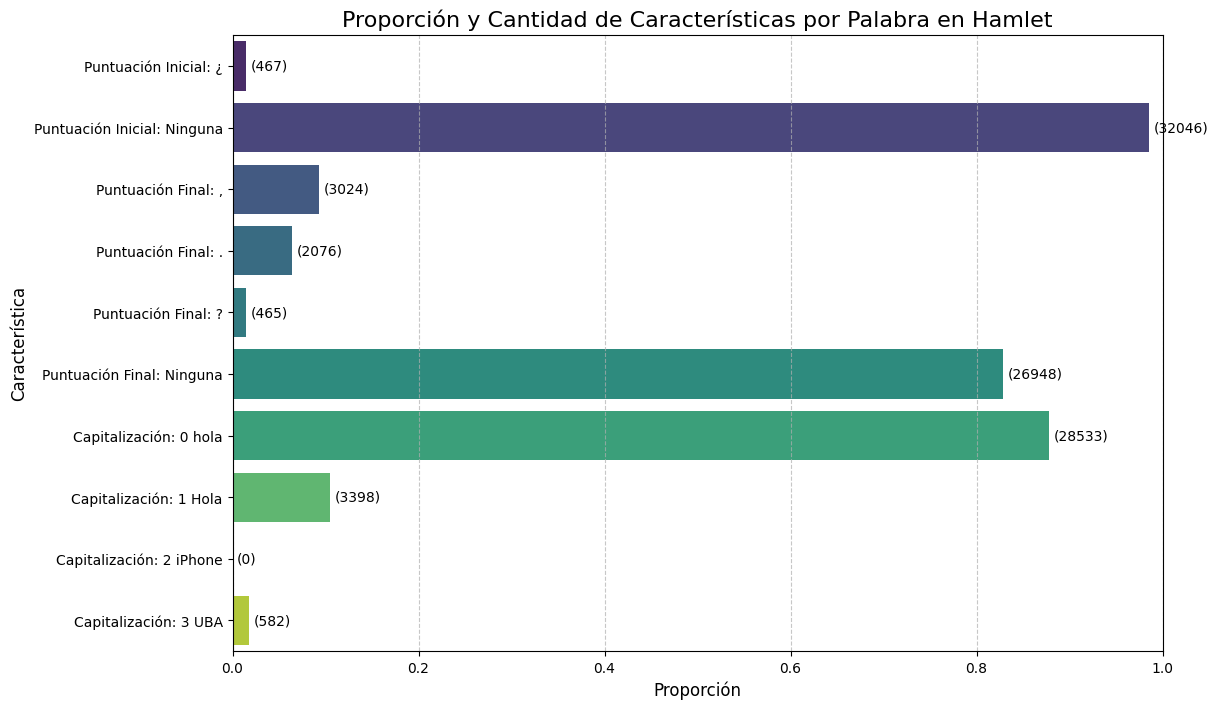

-- Resumen del Análisis por Palabra para Hamlet --
Total de palabras analizadas: 32513
Puntuación Inicial: ¿: 0.0144 (Cantidad: 467)
Puntuación Inicial: Ninguna: 0.9856 (Cantidad: 32046)
Puntuación Final: ,: 0.0930 (Cantidad: 3024)
Puntuación Final: .: 0.0639 (Cantidad: 2076)
Puntuación Final: ?: 0.0143 (Cantidad: 465)
Puntuación Final: Ninguna: 0.8288 (Cantidad: 26948)
Capitalización: 0 hola: 0.8776 (Cantidad: 28533)
Capitalización: 1 Hola: 0.1045 (Cantidad: 3398)
Capitalización: 2 iPhone: 0.0000 (Cantidad: 0)
Capitalización: 3 UBA: 0.0179 (Cantidad: 582)
------------------------------


In [11]:
# Analizar y graficar el DataFrame de Hamlet por palabra
analyze_and_plot_word_features(df_hamlet, 'Hamlet')

#### Dataset La Dama Boba

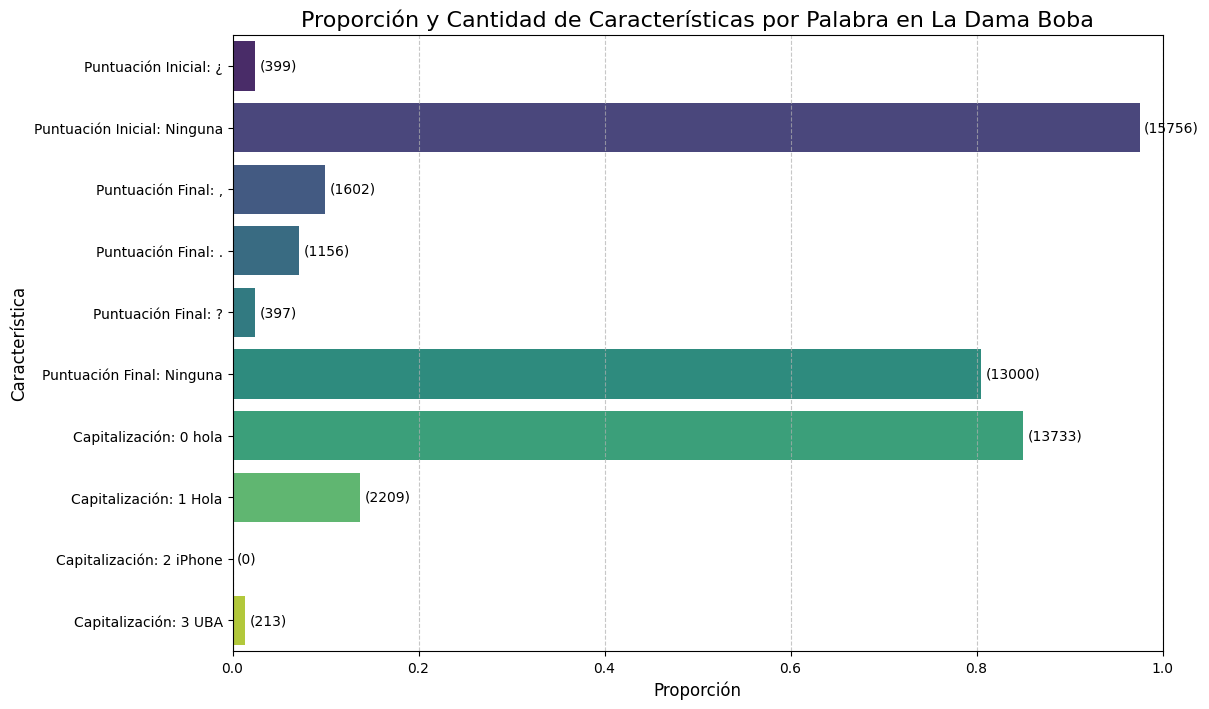

-- Resumen del Análisis por Palabra para La Dama Boba --
Total de palabras analizadas: 16155
Puntuación Inicial: ¿: 0.0247 (Cantidad: 399)
Puntuación Inicial: Ninguna: 0.9753 (Cantidad: 15756)
Puntuación Final: ,: 0.0992 (Cantidad: 1602)
Puntuación Final: .: 0.0716 (Cantidad: 1156)
Puntuación Final: ?: 0.0246 (Cantidad: 397)
Puntuación Final: Ninguna: 0.8047 (Cantidad: 13000)
Capitalización: 0 hola: 0.8501 (Cantidad: 13733)
Capitalización: 1 Hola: 0.1367 (Cantidad: 2209)
Capitalización: 2 iPhone: 0.0000 (Cantidad: 0)
Capitalización: 3 UBA: 0.0132 (Cantidad: 213)
------------------------------


In [12]:
# Analizar y graficar el DataFrame de La Dama Boba por palabra
analyze_and_plot_word_features(df_dama_boba, 'La Dama Boba')

#### Dataset Wikipedia

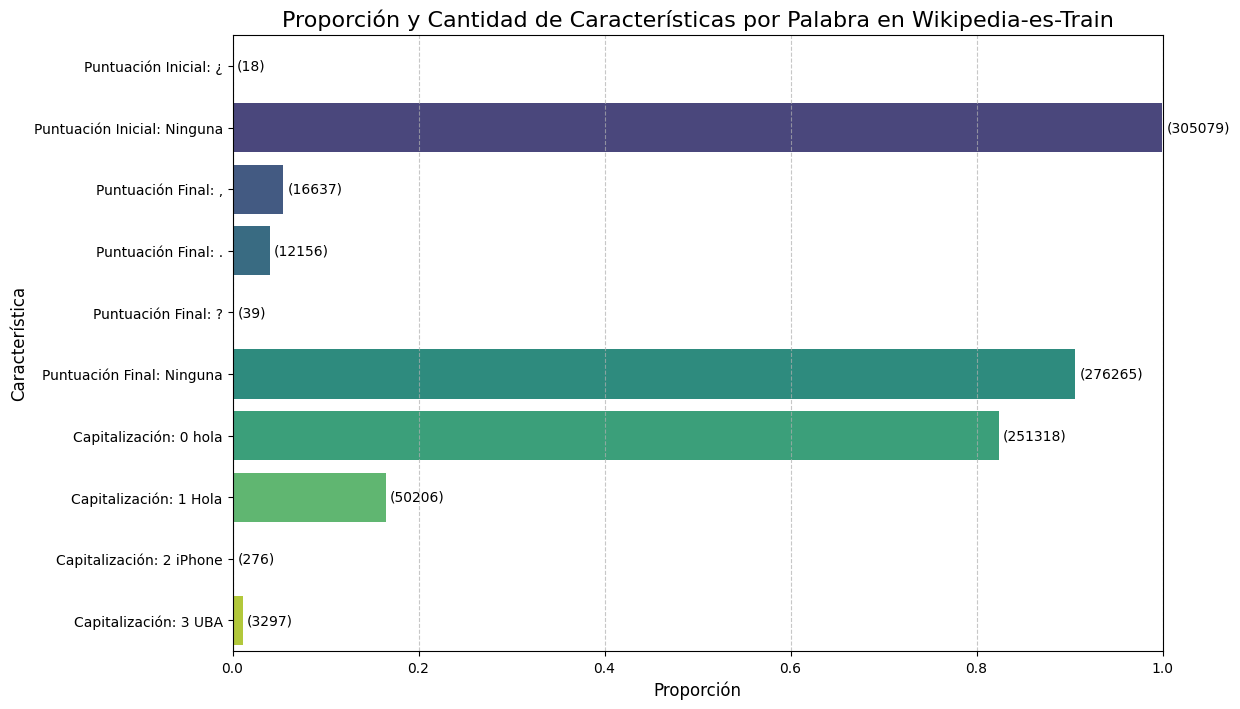

-- Resumen del Análisis por Palabra para Wikipedia-es-Train --
Total de palabras analizadas: 305097
Puntuación Inicial: ¿: 0.0001 (Cantidad: 18)
Puntuación Inicial: Ninguna: 0.9999 (Cantidad: 305079)
Puntuación Final: ,: 0.0545 (Cantidad: 16637)
Puntuación Final: .: 0.0398 (Cantidad: 12156)
Puntuación Final: ?: 0.0001 (Cantidad: 39)
Puntuación Final: Ninguna: 0.9055 (Cantidad: 276265)
Capitalización: 0 hola: 0.8237 (Cantidad: 251318)
Capitalización: 1 Hola: 0.1646 (Cantidad: 50206)
Capitalización: 2 iPhone: 0.0009 (Cantidad: 276)
Capitalización: 3 UBA: 0.0108 (Cantidad: 3297)
------------------------------


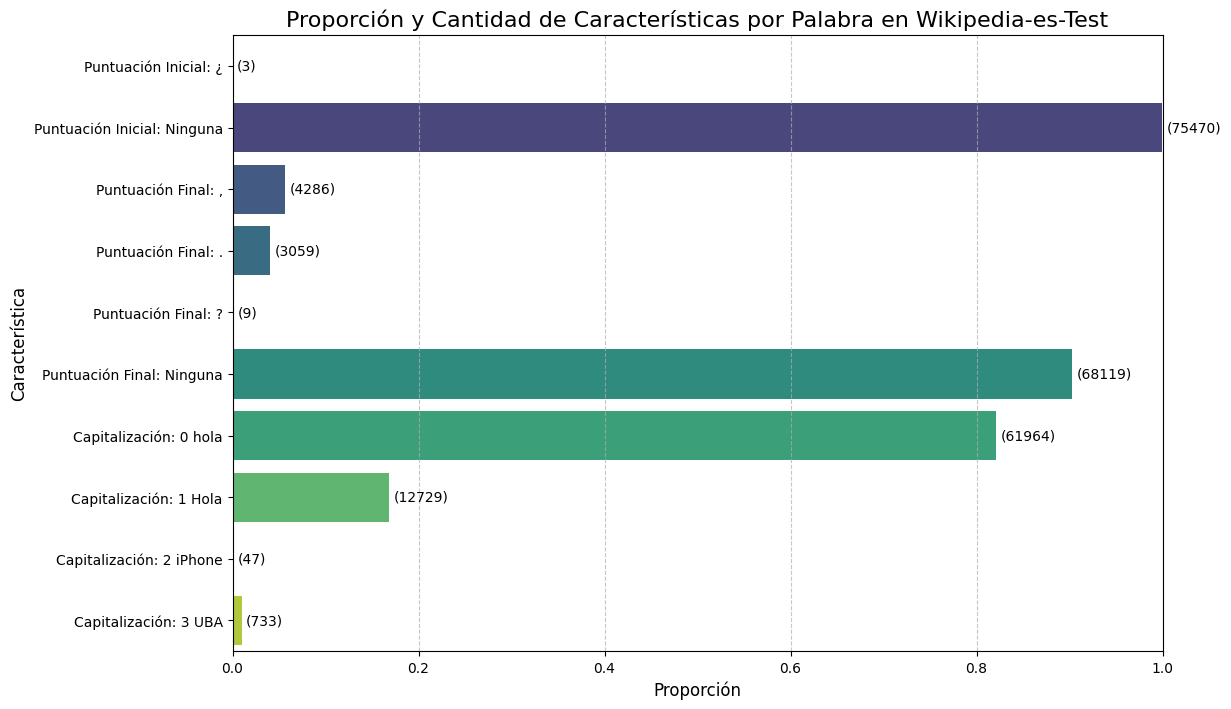

-- Resumen del Análisis por Palabra para Wikipedia-es-Test --
Total de palabras analizadas: 75473
Puntuación Inicial: ¿: 0.0000 (Cantidad: 3)
Puntuación Inicial: Ninguna: 1.0000 (Cantidad: 75470)
Puntuación Final: ,: 0.0568 (Cantidad: 4286)
Puntuación Final: .: 0.0405 (Cantidad: 3059)
Puntuación Final: ?: 0.0001 (Cantidad: 9)
Puntuación Final: Ninguna: 0.9026 (Cantidad: 68119)
Capitalización: 0 hola: 0.8210 (Cantidad: 61964)
Capitalización: 1 Hola: 0.1687 (Cantidad: 12729)
Capitalización: 2 iPhone: 0.0006 (Cantidad: 47)
Capitalización: 3 UBA: 0.0097 (Cantidad: 733)
------------------------------


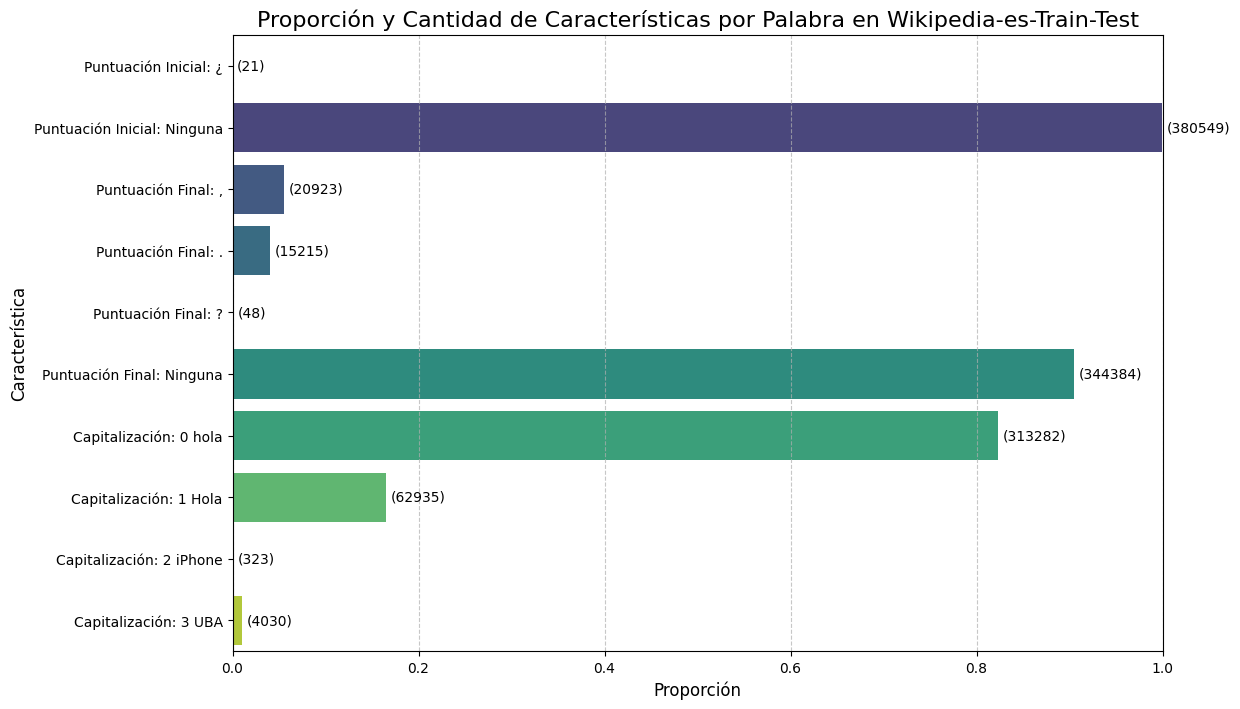

-- Resumen del Análisis por Palabra para Wikipedia-es-Train-Test --
Total de palabras analizadas: 380570
Puntuación Inicial: ¿: 0.0001 (Cantidad: 21)
Puntuación Inicial: Ninguna: 0.9999 (Cantidad: 380549)
Puntuación Final: ,: 0.0550 (Cantidad: 20923)
Puntuación Final: .: 0.0400 (Cantidad: 15215)
Puntuación Final: ?: 0.0001 (Cantidad: 48)
Puntuación Final: Ninguna: 0.9049 (Cantidad: 344384)
Capitalización: 0 hola: 0.8232 (Cantidad: 313282)
Capitalización: 1 Hola: 0.1654 (Cantidad: 62935)
Capitalización: 2 iPhone: 0.0008 (Cantidad: 323)
Capitalización: 3 UBA: 0.0106 (Cantidad: 4030)
------------------------------


In [13]:
# Convertir el split 'train' del dataset ds a un DataFrame
df_wikipedia_train = ds['train'].to_pandas()

# Convertir el split 'test' del dataset ds a un DataFrame
df_wikipedia_test = ds['test'].to_pandas()

# Unir ambos DataFrames
df_wikipedia_combined = pd.concat([df_wikipedia_train, df_wikipedia_test], ignore_index=True)

analyze_and_plot_word_features(df_wikipedia_train, 'Wikipedia-es-Train', text_column='contenido')
analyze_and_plot_word_features(df_wikipedia_test, 'Wikipedia-es-Test', text_column='contenido')
analyze_and_plot_word_features(df_wikipedia_combined, 'Wikipedia-es-Train-Test', text_column='contenido')

### Gráficos por palabra union de todos los datasets

In [14]:
df_hamlet_text = df_hamlet[['sentence']].rename(columns={'sentence': 'text_content'})

df_dama_boba_text = df_dama_boba[['sentence']].rename(columns={'sentence': 'text_content'})

df_wikipedia_combined_text = df_wikipedia_combined[['contenido']].rename(columns={'contenido': 'text_content'})

# Unir todos los DataFrames
df_all_datasets_combined = pd.concat([df_hamlet_text, df_dama_boba_text, df_wikipedia_combined_text], ignore_index=True)


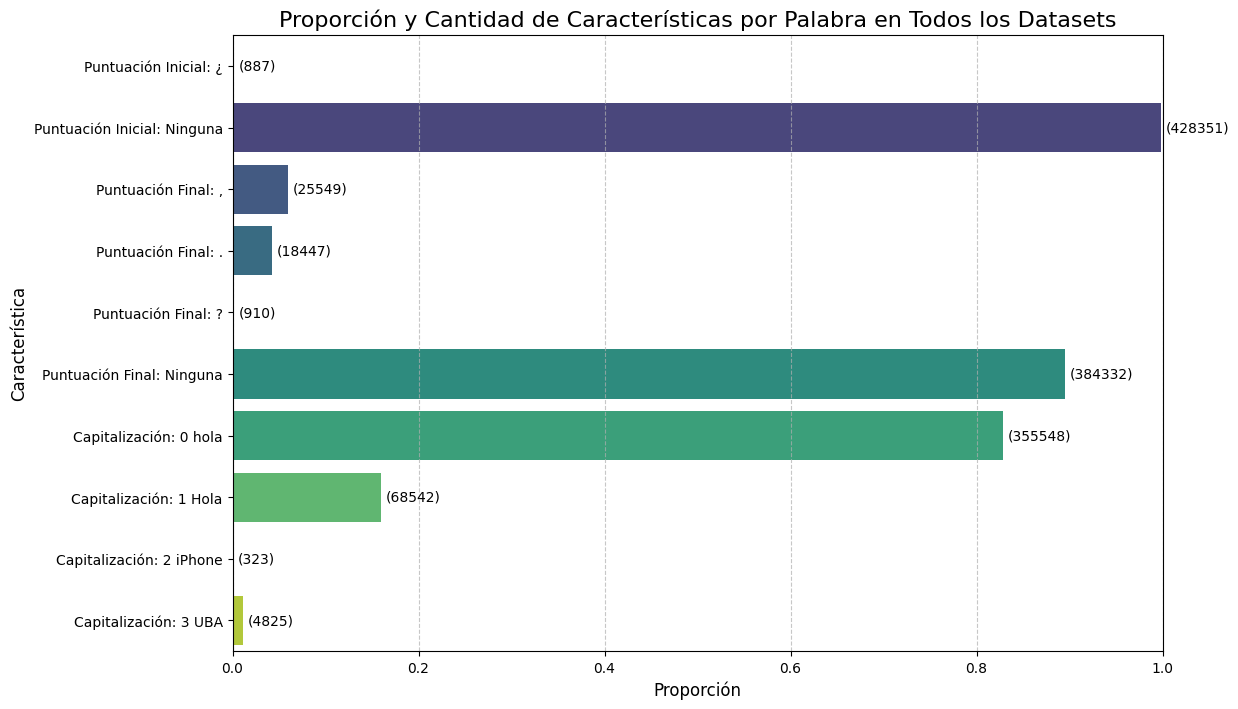

-- Resumen del Análisis por Palabra para Todos los Datasets --
Total de palabras analizadas: 429238
Puntuación Inicial: ¿: 0.0021 (Cantidad: 887)
Puntuación Inicial: Ninguna: 0.9979 (Cantidad: 428351)
Puntuación Final: ,: 0.0595 (Cantidad: 25549)
Puntuación Final: .: 0.0430 (Cantidad: 18447)
Puntuación Final: ?: 0.0021 (Cantidad: 910)
Puntuación Final: Ninguna: 0.8954 (Cantidad: 384332)
Capitalización: 0 hola: 0.8283 (Cantidad: 355548)
Capitalización: 1 Hola: 0.1597 (Cantidad: 68542)
Capitalización: 2 iPhone: 0.0008 (Cantidad: 323)
Capitalización: 3 UBA: 0.0112 (Cantidad: 4825)
------------------------------


In [15]:
# Analizar y graficar el DataFrame combinado de todos los datasets por palabra
analyze_and_plot_word_features(df_all_datasets_combined, 'Todos los Datasets', text_column='text_content')

# Ejemplo de uso nltk

In [16]:
wikipedia_full_text = df_wikipedia_combined['contenido'].str.cat(sep=' ')
print(f"Length of combined Wikipedia text: {len(wikipedia_full_text)} characters")
print(f"First 200 characters of combined Wikipedia text:\n{wikipedia_full_text[:200]}...")

Length of combined Wikipedia text: 2271548 characters
First 200 characters of combined Wikipedia text:
Grevillea vestita es un arbusto que es endémico de sudoeste de Australia Occidental . Alcanza usualmente los 3 metros de altura y tiene hojas con depresiones que llegan a los 50 mm de longitud y los 3...


In [18]:
import nltk
nltk.download('punkt', force=True)
nltk.download('punkt_tab', force=True)

wikipedia_sentences = nltk.sent_tokenize(wikipedia_full_text, language='spanish')
print(f"Number of sentences in Wikipedia: {len(wikipedia_sentences)}")
print("First 20 sentences of Wikipedia:\n")
for i, sentence in enumerate(wikipedia_sentences[:20]):
    print(f"{i+1}. {sentence}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Number of sentences in Wikipedia: 14817
First 20 sentences of Wikipedia:

1. Grevillea vestita es un arbusto que es endémico de sudoeste de Australia Occidental .
2. Alcanza usualmente los 3 metros de altura y tiene hojas con depresiones que llegan a los 50 mm de longitud y los 30 mm de ancho.
3. Las flores son blancas, crema y ocasionalmente rosa pálido y son más abundantes en invierno o primavera, aunque pueden florecer esporádicamente durante todo el año.
4. El tipo espécimen de esta especie fue encontrada en la región de King George Sound y descrita por el botánico austriaco Stephan Endlicher en 1839 que le dio el nombre de Manglesia vestita.
5. En 1845 Meissner incluye la especie en el género  Grevillea.
6. Grevillea vestita fue descrita por (Endl.)
7. Meisn.
8. y publicado en Plantae Preissianae 1: 548.
9. 1845.
10. [1]​ Grevillea, el nombre del género fue nombrado en honor de Charles Francis Greville, co-foundador de la Royal Horticultural Society.
11. El epíteto específico de v

# Análisis de tokens por oración

In [19]:

import re
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Usamos nltk para que nos divida en oraciones de una forma simple sin tener que escribir el código a mano
#Ver sentences_from_dataframe
nltk.download('punkt', force=True)


def clean_sentence_plaintext(sentence: str) -> str:
    """Quita puntuación y pasa a minúsculas. Conserva letras (con tildes) y números."""
    if sentence is None:
        return ""
    cleaned = re.sub(r'[\W_]+', ' ', str(sentence), flags=re.UNICODE)  # todo no alfanumérico -> espacio
    return cleaned.strip().lower()

def sentences_from_dataframe(df: pd.DataFrame, column: str, language: str = 'spanish') -> list:
    """Une la columna y segmenta en oraciones con nltk (si ya tenés oraciones, no hace falta usarla)."""
    # full_text = "Hola, ¿cómo estás? Yo muy bien. Este es otro ejemplo. Tiene dos oraciones."
    # nltk.tokenize.sent_tokenize(text, language=language) ->
    # ["Hola, ¿cómo estás?",
    #"Yo muy bien.",
    #"Este es otro ejemplo.",
    #"Tiene dos oraciones."]
    text = df[column].astype(str).str.cat(sep=' ')
    return nltk.tokenize.sent_tokenize(text, language=language)

def bert_token_count_sentence(sentence: str, tokenizer, include_special_tokens: bool = False) -> int:
    """
    Cuenta subtokens BERT para una oración ya limpia (la función limpia internamente).
    Si include_special_tokens=True cuenta [CLS]/[SEP].
    """
    cleaned = clean_sentence_plaintext(sentence)
    if include_special_tokens:
        ids = tokenizer.encode(cleaned, add_special_tokens=True)
        return len(ids)
    else:
        toks = tokenizer.tokenize(cleaned)
        return len(toks)

def process_sentences_list(sentences: list, tokenizer, include_special_tokens: bool = False) -> pd.DataFrame:
    """
    Convierte una lista de oraciones en DataFrame con columnas:
    - sentence (original)
    - cleaned (texto plano, lowercase)
    - word_count_plain (split sobre cleaned)
    - bert_token_count (subtokens BERT)
    """
    rows = []
    for s in sentences:
        cleaned = clean_sentence_plaintext(s)
        word_count = len(cleaned.split()) if cleaned else 0
        bert_count = bert_token_count_sentence(cleaned, tokenizer, include_special_tokens=include_special_tokens)
        rows.append({"sentence": s, "cleaned": cleaned, "word_count_plain": word_count, "bert_token_count": bert_count})
    return pd.DataFrame(rows)

def process_dataframe(df: pd.DataFrame, column: str, tokenizer, include_special_tokens: bool = False, language: str = 'spanish', max_sentences: int = None) -> pd.DataFrame:
    """Conveniencia: extrae oraciones de un DataFrame y las procesa (usa sentences_from_dataframe)."""
    sents = sentences_from_dataframe(df, column, language=language)
    if max_sentences is not None:
        sents = sents[:max_sentences]
    return process_sentences_list(sents, tokenizer, include_special_tokens=include_special_tokens)

def quick_stats(df_counts: pd.DataFrame, col: str = "bert_token_count") -> dict:
    a = df_counts[col].to_numpy()
    return {
        "n_sentences": int(len(a)),
        "mean": float(np.mean(a)) if len(a) else 0.0,
        "median": float(np.median(a)) if len(a) else 0.0,
        "std": float(np.std(a)) if len(a) else 0.0,
        "min": int(np.min(a)) if len(a) else 0,
        "max": int(np.max(a)) if len(a) else 0
    }

def plot_line(df_counts: pd.DataFrame, col: str = "bert_token_count", title: str = None, figsize=(14,4)):
    plt.figure(figsize=figsize)
    sns.lineplot(x=range(len(df_counts)), y=df_counts[col])
    plt.title(title or f'Line plot: {col}')
    plt.xlabel('Número de oración')
    plt.ylabel(col)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

def plot_hist(df_counts: pd.DataFrame, col: str = "bert_token_count", bins: int = 40, title: str = None, figsize=(10,4)):
    plt.figure(figsize=figsize)
    sns.histplot(df_counts[col], bins=bins, kde=False)
    plt.title(title or f'Histograma: {col}')
    plt.xlabel(col)
    plt.ylabel('Número de oraciones')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Dama Boba: {'n_sentences': 1725, 'mean': 12.859710144927536, 'median': 9.0, 'std': 12.494962459827793, 'min': 0, 'max': 131}
Hamlet   : {'n_sentences': 2607, 'mean': 17.39355581127733, 'median': 11.0, 'std': 17.878271981056407, 'min': 1, 'max': 154}
Wikipedia: {'n_sentences': 14817, 'mean': 33.88776405480192, 'median': 29.0, 'std': 22.783300564532592, 'min': 0, 'max': 609}


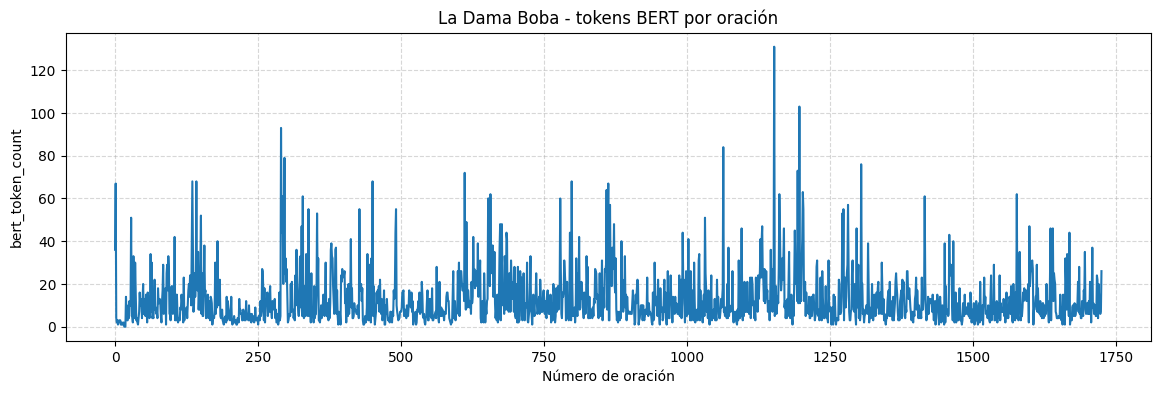

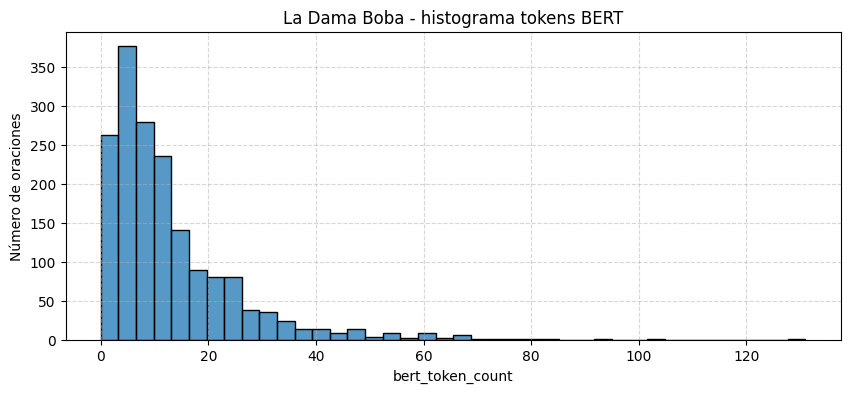

In [20]:
model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)


# Procesar cada dataset (sin tokens especiales)
df_dama = process_dataframe(df_dama_boba, column='sentence', tokenizer=tokenizer, include_special_tokens=False)
df_hamlet = process_dataframe(df_hamlet, column='sentence', tokenizer=tokenizer, include_special_tokens=False)
df_wiki  = process_dataframe(df_wikipedia_combined, column='contenido', tokenizer=tokenizer, include_special_tokens=False)

# Estadísticas rápidas
print("Dama Boba:", quick_stats(df_dama))
print("Hamlet   :", quick_stats(df_hamlet))
print("Wikipedia:", quick_stats(df_wiki))

# Plots la dama boba
plot_line(df_dama, col='bert_token_count', title='La Dama Boba - tokens BERT por oración')
plot_hist(df_dama, col='bert_token_count', title='La Dama Boba - histograma tokens BERT')


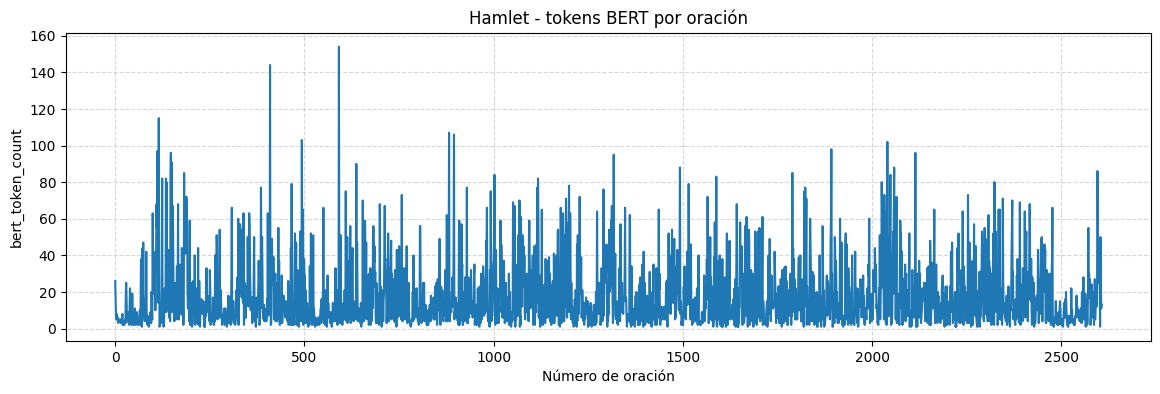

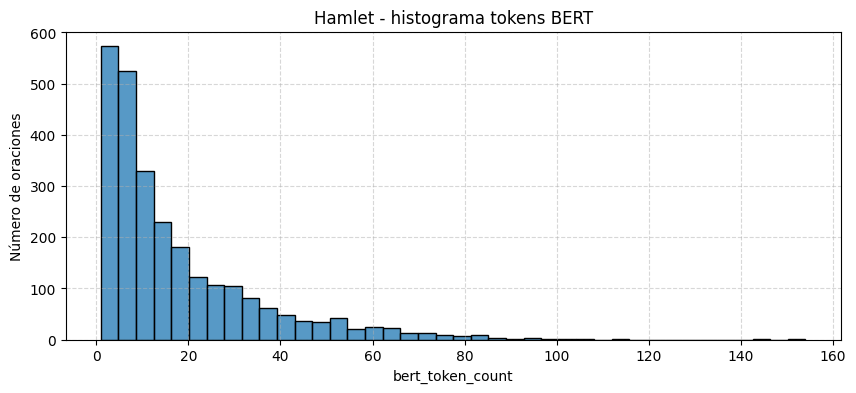

In [21]:
plot_line(df_hamlet, col='bert_token_count', title='Hamlet - tokens BERT por oración')
plot_hist(df_hamlet, col='bert_token_count', title='Hamlet - histograma tokens BERT')

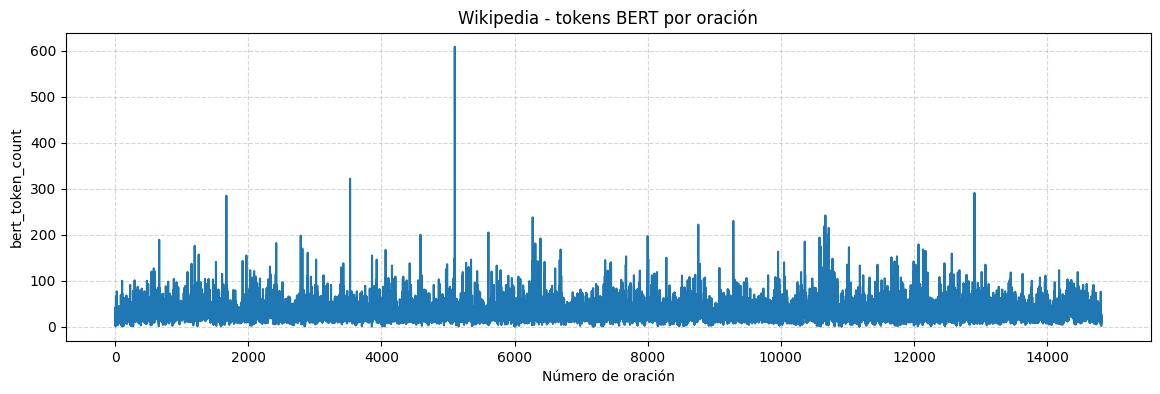

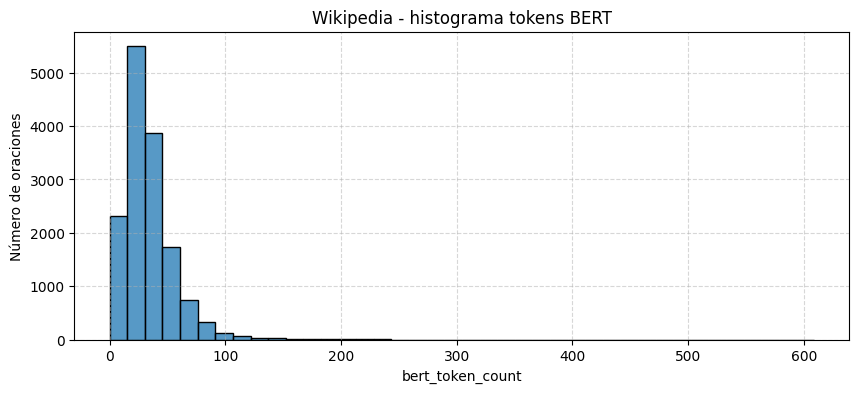

In [22]:
plot_line(df_wiki, col='bert_token_count', title='Wikipedia - tokens BERT por oración')
plot_hist(df_wiki, col='bert_token_count', title='Wikipedia - histograma tokens BERT')